# Hydrogel-Cell Interaction

In this case, we only have the deformed shape of the spherical hydrogel as shown in the next few cells.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os.path
from itertools import permutations

module_path = '../module/'
sys.path.append(module_path)
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord

import pyshtools
from SHUtil import SHCilmToVector, SHVectorToCilm, lmk2K, K2lmk
from SHUtil import plotfv, TransMat, l_coeffs, m_coeffs
from ShElastic import calSmode, calUmode
from SHBV import generate_submat, visualize_Cmat, print_SH_mode

from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize

from Case05_utilities import Uvec2Tvec, Tvec2Uvec
from Case05_utilities import SHVec2mesh, visSHVec, visSH3d
from Case05_utilities import SHvec_rtoc, SHvec_ctor
from Case05_utilities import generate_fcache, generate_Xneigh, generate_Eneigh, generate_Fneigh

In [2]:
############################# change inputs here #################################
# Data file name
datadir = '../testdata'
smoothed = 'smoothed'; smoothed = '';
dilated = '_1um_dilated';# dilated = '';
shapename = 'Shape2'
datafile = os.path.join(datadir, shapename+'_Coordinates_Cart_'+smoothed+'.csv')
connfile = os.path.join(datadir, shapename+'_Connectivity.csv')
maskfile = os.path.join(datadir, shapename+'_Mask'+dilated+'.csv')

# Material properties
mu0 = 300/3;
mu = 1.; nu = 0.499;
# Spherical Harmonics Analysis Settings
lJmax = 20; lKmax = 20; lmax_plot = 60;
lmax_work = 16; lmax_buf = lJmax-lmax_work;

# neibor list settings
n_list = 1000
n_load = 10
n_recal_neigh = 1
file_neigh = shapename + '_neigh%d_lmax%d'%(n_list, lJmax) + smoothed + dilated

# regularizations
myalpha = 0.1   # traction magnitude
mybeta  = 0.05  # coefficient magnitude

# program switches
plot_figure = True
node_face_dist_on = None
opt_proc = [2, ] #0, 1, 0, 1, 0, 1, 0, 1, 0]  # 1: node-face on; 0: node-face off;

# minimization settings
N_period = 2000
maxiter_per_period = 20
CG_gtol = 1e-4
minimizer = 'CG'
minimizer_config = {'maxiter': maxiter_per_period, 'gtol': CG_gtol, 'disp': True}
# method='Powell', options={'maxiter':1, 'maxfev':10, 'disp': True})

# dump files for minimization
AKfile = 'AK_solution.npy'
fvfile = 'fv.txt'

# settings for loading \hat{U}, \hat{T} coefficients
shtype = 'reg'
coeff_dir = os.path.join(module_path, 'lmax%dmodes'%60)
#################################################################################

Umodes = loadmat(os.path.join(coeff_dir,'Umodes.mat'))
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax, kJ=3).tocsc()

Tmodes = loadmat(os.path.join(coeff_dir,'Tmodes.mat'))
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax, kJ=3).tocsc()

data, connectivity: (8136, 3) (16268, 3)
id of nodes, edges, facets: (8136,) (24402, 2) (16268, 3)
coord of nodes, edges, facets: (8136, 3) (24402, 2, 3) (16268, 3, 3)
Traction free boundary of v, e, f: (8136,) (24402,) (16268,)


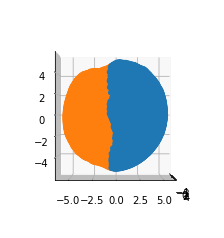

In [3]:
#### load the geometry ####
# Vs, Vp: list of nodes (nV, trivial), coordinates of the nodes (nVx3)
# Es, Ep: list of edges (nEx2), list of points on the edges (nEx2x3)
# Fs, Fp: list of facets (nFx3), list of points on the facets (nFx3x3)
# Tfv: traction free boundary map of the node list
# Tfe: traction free boundary map of the edge list
# Tff: traction free boundary map of the face list
# Tf_diluted: diluted traction free boundary map

data = np.genfromtxt(datafile, delimiter=',')
conn = np.genfromtxt(connfile, delimiter=',', dtype=np.int)
if shapename == 'Shape4':
    mask = np.zeros_like(data[:,0]).astype(np.int)
else:
    mask = np.genfromtxt(maskfile, dtype=np.int)
print('data, connectivity:', data.shape, conn.shape)

Fs = conn - 1
Np = data.shape[0]
Vs = np.arange(Np)
edge_conn = spm.lil_matrix((Np, Np), dtype=bool)
for i, j in permutations(range(3), 2):
    edge_conn[Fs[:, i], Fs[:, j]] = True
Es = spm.triu(edge_conn).tocoo()
Es = np.vstack([Es.row, Es.col]).T
print('id of nodes, edges, facets:', Vs.shape, Es.shape, Fs.shape)
Vp = data[..., :3]
Ep = Vp[Es, :]; Fp = Vp[Fs, :];
print('coord of nodes, edges, facets:', Vp.shape, Ep.shape, Fp.shape)

#Tf_diluted = data[:, 4].astype(np.bool)
#Tfv = np.logical_not(data[:, 3].astype(np.bool))
Tfv = mask.astype(np.bool) # np.logical_not(mask.astype(np.bool))
Tfe = np.all(Tfv[Es], axis=1)
Tff = np.all(Tfv[Fs], axis=1)
print('Traction free boundary of v, e, f:', Tfv.shape, Tfe.shape, Tff.shape)

#### Plot the geometry (Vp) ####
if plot_figure:
    fig = plt.figure()#figsize=(16,16))
    ax = fig.add_subplot(111, projection='3d')

    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2])
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2])

    eTf = Line3DCollection(np.hstack([Ep[Tfe, 0, :], Ep[Tfe, 1, :]]).copy().reshape((-1,2,3)), colors='C0')
    ax.add_collection(eTf)
    nTfe = np.logical_not(Tfe)
    eTf = Line3DCollection(np.hstack([Ep[nTfe, 0, :], Ep[nTfe, 1, :]]).copy().reshape((-1,2,3)), colors='C1')
    ax.add_collection(eTf)

    ax.view_init(azim=0, elev=0)

    ax.set_aspect('equal')
    plt.show()

Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

In [4]:
tet = np.zeros((Fs.shape[0], 4, 4))
tet[:,:-1,:-1] = Fp
tet[:,:,-1] = 1
vol = np.sum(np.linalg.det(tet)/6, axis=0)
r0 = np.cbrt(vol/(4/3*np.pi))
print('V = %.4f, r0 = %.4f'%(vol, r0))

V = 607.3097, r0 = 5.2534


We need to solve the reverse problem of a deformed shape. We will try the following methods to tackle this problem:

1. Assume $r$-direction deformation only, using the solution as initial guess to the optimization
2. LSQ solving coeffs of the SH solutions for fitting both the traction-free boundary and the shape

## 1. Assume $r$-direction deformation only

First thing to try is assuming that the deformation only happens on $r$-direction.

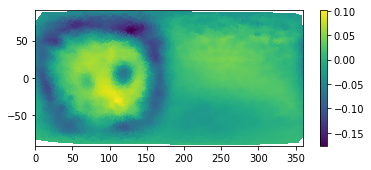

In [5]:
# Vp -> ur (radial displacement) -> u1 (x,y,z)
Vr, Vthe, Vphi = CartCoord_to_SphCoord(Vp[...,0], Vp[...,1], Vp[...,2])
Vphi[Vphi < 0] += 2*np.pi
Vlat = 90-np.rad2deg(Vthe)
Vlon = np.rad2deg(Vphi)

ur = (Vr - r0)/r0

# displacement on the unit sphere
#u1 = -(r0/Vr[:,np.newaxis]-1)*Vp/r0 #(Vr/r0-1)[...,np.newaxis]*Vp
u1 = ur[:,np.newaxis] * (Vp/Vr[:,np.newaxis])

# plot 2d map of the radial displacement
if plot_figure:
    pVlon = Vlon - 180
    pVlon[pVlon < 0] += 360
    plt.figure(figsize=(6,2.5))
    plt.tripcolor(pVlon, Vlat, ur)
    plt.colorbar()
    plt.axis('equal')
    plt.xlim(0, 360)
    plt.ylim(-90, 90)
    plt.show()

### NOTE: All the displacements are normalized with $r_0$, and tractions are normalized with $\mu_0$

We expand $u_r$ and obtain regular-mesh representation, then obtain $u_x,u_y,u_z$ from $u_r$ on regular mesh ($u_\theta=u_\varphi=0$).

In [6]:
urcilm, chi2 = pyshtools.expand.SHExpandLSQ(ur, Vlat, Vlon, lmax=lJmax)
print(chi2)
urcoeffs = pyshtools.SHCoeffs.from_array(urcilm)
urcoeffs.info()
spec_before = urcoeffs.spectrum(unit='per_lm')

if plot_figure:
    fig, ax = urcoeffs.plot_spectrum(unit='per_lm')

0.11092364380079114
kind = 'real'
normalization = '4pi'
csphase = 1
lmax = 20


### Develop the interpolation function for $r(\theta,\varphi)$ from data

In [7]:
urcilm_interp, chi2 = pyshtools.expand.SHExpandLSQ(ur, Vlat, Vlon, lmax=lmax_plot+10)
print(chi2)

0.005560216061454072


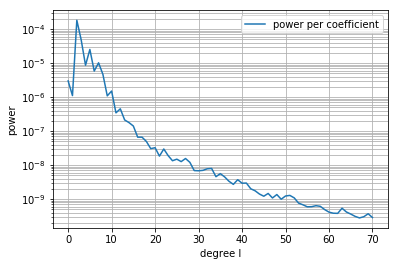

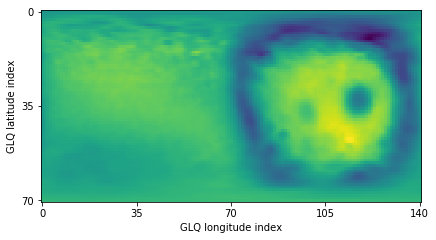

kind = 'real'
grid = 'GLQ'
nlat = 71
nlon = 141
lmax = 70


In [8]:
ucoeff_interp = pyshtools.SHCoeffs.from_array(urcilm_interp)
urgrid_interp = ucoeff_interp.expand('GLQ')

if plot_figure:
    fig, ax = ucoeff_interp.plot_spectrum(unit='per_lm')
    fig, ax = urgrid_interp.plot()
    urgrid_interp.info()
#print(urgrid_interp.lons(), urgrid)

In [9]:
from scipy.interpolate import interp2d, RectBivariateSpline, RegularGridInterpolator

lats = urgrid_interp.lats(); lons = urgrid_interp.lons()
lats_circular = np.hstack(([90.], lats, [-90.]))
lons_circular = np.append(lons, 360)
#print(np.diff(lats_circular))
#print(lats_circular, lons_circular)
LONS, LATS = np.meshgrid(lons_circular, lats_circular)
xmesh = urgrid_interp.to_array().copy()
fpoints = np.zeros_like(LONS)
fpoints[1:-1, :-1] = xmesh
fpoints[0, :] = np.mean(xmesh[0,:], axis=0)  # not exact !
fpoints[-1, :] = np.mean(xmesh[-1,:], axis=0)  # not exact !
fpoints[1:-1, -1] = xmesh[:, 0]
print(LATS.shape, LONS.shape, fpoints.shape)
print(lats_circular.shape, lons_circular.shape)
f_interp = RectBivariateSpline(lats_circular[::-1], lons_circular, fpoints[::-1, ], kx=1, ky=1)

(73, 142) (73, 142) (73, 142)
(73,) (142,)


In [10]:
## Test the interpolation algorithm

tic = time.time()
ur_interp = f_interp.ev(Vlat, Vlon)
toc = time.time()
print(f_interp.get_coeffs().shape)
print(ur_interp.shape, toc-tic)
print(ur_interp - ur)

if plot_figure:
    plt.figure(figsize=(6,5))
    plt.subplot(211)
    plt.tripcolor(pVlon, Vlat, ur)
    plt.colorbar()
    plt.axis('equal')
    plt.xlim(0, 360)
    plt.ylim(-90, 90)
    plt.subplot(212)
    plt.tripcolor(pVlon, Vlat, ur_interp)
    plt.colorbar()
    plt.axis('equal')
    plt.xlim(0, 360)
    plt.ylim(-90, 90)
    plt.show()

(10366,)
(8136,) 0.002172231674194336
[ 4.33832729e-03 -9.90183663e-04 -2.33334366e-03 ... -3.40936281e-05
 -5.94020223e-05 -7.89806703e-05]


In [11]:
from scipy.special import erfc
# damp the high order coefficients
lmax_mean = lmax_work + np.int(lmax_buf/2);
ldamp = erfc((l_coeffs(lJmax) - lmax_mean)/(lmax_buf/4))/2

urcoeffs = pyshtools.SHCoeffs.from_array(urcilm*ldamp)
spec_after = urcoeffs.spectrum(unit='per_lm')

if plot_figure:
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.plot(ldamp[0,:,0])
    plt.subplot(122)
    plt.semilogy(spec_before); plt.semilogy(spec_after);
    plt.legend(['before damping', 'after damping'])
    plt.show()

In [12]:
urgrid = urcoeffs.pad(lmax=lmax_plot).expand('GLQ')
urgrid.info()

if plot_figure:
    urgrid_plot = urgrid.copy()
    urgrid_plot.data = np.roll(urgrid.data, lmax_plot+1, axis=1)
    fig, ax = urgrid_plot.plot()

kind = 'real'
grid = 'GLQ'
nlat = 61
nlon = 121
lmax = 60


In [13]:
# Convert Back to ux,uy,uz on regular mesh
Q = TransMat(lJmax=urgrid.lmax)
print('Size of transfer matrix:', Q.shape)
u1a = urgrid.data[:,:,np.newaxis]*Q[:, :, 0, :]
print('Size of Cartesian representation of displacement:', u1a.shape)

Size of transfer matrix: (61, 121, 3, 3)
Size of Cartesian representation of displacement: (61, 121, 3)


In [14]:
# Construct initial guess AK
# decompose the displacement field into spherical harmonic coefficients
U1avec0 = [None for _ in range(3)]
for k in range(3):
    u1agrid = pyshtools.SHGrid.from_array(u1a[...,k].astype(np.complex), grid='GLQ')
    u1acoeffs = u1agrid.expand().pad(lmax=lJmax)
    U1avec0[k] = SHCilmToVector(u1acoeffs.to_array())
U1avec0 = np.hstack(U1avec0)

if plot_figure:
    print('Displacement in Spherical Coordinates...')
    fig, ax = visSHVec(U1avec0*r0, lmax_plot=80, SphCoord=True, Complex=True, s_vrange=(0,0.01),
                           config_quiver=(2, 3, 'k', 0.2), lonshift=180, figsize=(6,3))
    
if plot_figure:
    print('SH Coefficients of the Initial Guess Displacement...U1avec0')
    plt.plot(np.abs(U1avec0))
    plt.ylim(0,0.001)
    plt.show()

from scipy.sparse.linalg import spsolve, cgs
AK_init = spsolve(Dmat.tocsc(), U1avec0.T);

if plot_figure:
    print('Coefficients of the Initial Guess in Solution Space...AK')
    plt.plot(np.abs(AK_init)); 
    plt.ylim(0,0.001);
    plt.show();

## 2. LSQ solving SH coeffs for displacement field

Obviously, the decomposition is not satisfactory. It is not reasonable to assume the deformation is only on $r$-direction. In this section, we will try to optimize SH coeffs, so that the deformed shape is closest to the data. Notice that the integral of a spherical harmonic function on the sphere surface is:

$$
\int_0^{2\pi}\!\int_0^{\pi}Y_l^m(\theta,\varphi)\sin\theta d\theta d\varphi = 4\pi\delta_{l0}\delta_{m0}
$$

Therefore, only the $Y_0^0$ term controls the rigid body translation (constant). If we only impose higher mode spherical harmonics, there will be no rigid body motion.

### 2.1 Developing shape-difference function and neighbor list

We first develop the distance function of the point sets to the surface. The distance of a point $x$ to the surface is defined as: $d(x) = \min[d_{v}(x), d_{e}(x), d_{f}(x)]$, where $d_v(x)$, $d_e(x)$, $d_f(x)$ are the closest distances of $x$ to the vertices, edges, and faces respectively.

* For a vertex $v=(v_1,v_2,v_3)^T$, $d_v(x)=\|\mathbf{x-v}\|_2$. The test script is attached.

* For an edge $e=(r_1, r_2)$, the projection point $\vec{r_1q}$ on $\vec{r_1r_2}$ is 
$$
\vec{r_1q} = \frac{\vec{r_1x}\cdot\vec{r_1r_2}}{\|\vec{r_1r_2}\|}\,\frac{\vec{r_1r_2}}{\|\vec{r_1r_2}\|}
$$

The projection is in the interval $r_1r_2$ if $t=\|\vec{r_1q}\|/\|\vec{r_1r_2}\|\in(0,1)$. 
Thus, the distance to the edge is calculated as:
$$
d_e(x)=
\begin{cases}
\|\vec{r_1x}\|,\; t\le0 \\
\|\vec{qx}\|,\; 0<t\le1 \\
\|\vec{r_2x}\|,\; t>1 
\end{cases}
$$
A test case is attached here.

* For a face $f=(r_1, r_2, r_3)$, the normal vector:
$$
n = \frac{\vec{r_1r_2}\times\vec{r_1r_3}}{\|\vec{r_1r_2}\times\vec{r_1r_3}\|}
$$
Then the distance can be calculated as:
$$
d_f(x)=\|\vec{r_1x}\cdot\vec{n}\|
$$
if the projection point $q$ is in the triangle, where $q = x - (\vec{r_1x}\cdot\vec{n})\vec{n}$.

To test this, we calculate the barycentric coordinates of $q$:
$$
b_3 = \frac{\|r_1\|^2\times(\vec{r_1r_3}\cdot\vec{r_1q})-
            (\vec{r_1r_2}\cdot\vec{r_1r_3})\times(\vec{r_1r_2}\cdot\vec{r_1q})}
           {\|r_1\|^2\|r_2\|^2-(\vec{r_1r_2}\cdot\vec{r_1r_3})^2}\\
b_2 = \frac{\|r_2\|^2\times(\vec{r_1r_2}\cdot\vec{r_1q})-
            (\vec{r_1r_2}\cdot\vec{r_1r_3})\times(\vec{r_1r_3}\cdot\vec{r_1q})}
           {\|r_1\|^2\|r_2\|^2-(\vec{r_1r_2}\cdot\vec{r_1r_3})^2}\\
b_1 = 1 - b_2 - b_3
$$

If any $b_i < 0$, $q$ is outside of the triangle, we then calculate the point edge distances $d_e(x)$ instead.

With the distance function ready, we can develop the neighbor list by choosing the closest `n_list` vertices, edges and faces to the points:

In [15]:
# Shape of the initial guess U1avec0: Xt = X0 + u1a
latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lJmax)
lon = np.deg2rad(lonsdeg)
colat = np.deg2rad(90-latsdeg)
PHI, THETA = np.meshgrid(lon, colat)
R = np.ones_like(PHI)
X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
X0 = np.stack([X,Y,Z], axis=-1)

Xt = X0 + SHVec2mesh(U1avec0, lmax=lJmax, SphCoord=False, Complex=True)

In [16]:
if not os.path.exists(file_neigh+'.npz'):
    #Xneigh, Eneigh, Fneigh = generate_neighbor_list(Xt, Xref=Vp/r0, Eref=Ep/r0, Fref=Fp/r0, filename=file_neigh, n_list=n_list)
    Xneigh = generate_Xneigh(Xt, Vp/r0, n_list=n_list, filename=file_neigh)
    Eneigh = generate_Eneigh(Xt, Ep/r0, n_list=n_list, filename=file_neigh)
    Fneigh = generate_Fneigh(Xt, Fp/r0, n_list=n_list, filename=file_neigh)
    np.savez(file_neigh, Xneigh=Xneigh, Eneigh=Eneigh, Fneigh=Fneigh)

Xneigh = np.load(file_neigh+'.npz')['Xneigh'][...,:n_load,:]
Eneigh = np.load(file_neigh+'.npz')['Eneigh'][...,:n_load,:,:]
Fneigh = np.load(file_neigh+'.npz')['Fneigh'][...,:n_load,:,:]
print('Neighbor list:', Xneigh.shape, Eneigh.shape, Fneigh.shape)

Neighbor list: (21, 41, 10, 3) (21, 41, 10, 2, 3) (21, 41, 10, 3, 3)


Visualize the neighbor list on deformed shape:

In [17]:
if plot_figure:
    i = np.int(lJmax/4); j = np.int(3*lJmax/2)+1; k = np.int(lJmax/2)
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(Xt[0:k,:, 0], Xt[0:k,:, 1], Xt[0:k,:, 2])
    ax.scatter3D(Xt[i, j, 0], Xt[i, j, 1], Xt[i, j, 2], s=200)
    ax.scatter3D(Xneigh[i, j, :, 0], Xneigh[i, j, :, 1], Xneigh[i, j, :, 2], marker = '^')
    ax.view_init(azim=-90, elev=0)
    ax.set_zlim3d(0, 1); ax.set_xlim3d(-0.5, 0.5); ax.set_ylim3d(-1, 0)
    plt.show()

### 2.2  From `uvec` to the shape difference

After we obtain the neighbor list, the shape can be obtained from the real SH vector `uvec`. This can be used for the optimization of the shape.

In [18]:
from SHUtil import LM_list
lat_weights = np.sin(THETA)**2
vert_weight = np.array([1,1,1./3])**2
l_list, m_list = LM_list(lJmax)

In [19]:
def coeffs2dr(uvec, f_interp=f_interp, lmax=None, X0=None, Complex=False,
              lat_weights=1, vert_weight=1, l_weight=None, debug=False):
    #### shape difference from SH vectors
    ## uvec: Input real SH vector (3x(lmax+1)^2)
    ## f_interp: interpolation function that calculates r(theta,phi)
    ## lmax, X0: pre-calculated parameters for speed-up. Explained in the code.
    ## Complex: Default False, uvec is the real SH vector using pyshtools.shio.SHVectorToCilm;
    ##          otherwise, it will be complex SH vector using SHUtil.SHVectorToCilm;
    ## lat_weights: weighing function for different densities of nodes on different lattitudes.
    ## vert_weight: weighing function for different error in different directions
    ## l_weight: weighing function for coefficients (anti-aliasing)
    if lmax is None:
        lmax = np.sqrt(uvec.size/3).astype(np.int) - 1
    nvec = (lmax+1)**2
    cvec = uvec.reshape(3, nvec)
    # expand the displacement field onto a mesh
    umesh= [None for _ in range(3)]
    for k in range(3):
        if Complex:
            cilm = SHVectorToCilm(cvec[k, :])
        else:
            cilm = pyshtools.shio.SHVectorToCilm(cvec[k, :])
        coeffs = pyshtools.SHCoeffs.from_array(cilm)
        grid = coeffs.expand('GLQ')
        umesh[k] = grid.to_array().real
    umesh = np.stack(umesh, axis=-1)
    # calculate the shape
    if X0 is None:
        lon = np.deg2rad(grid.lons())
        colat = np.deg2rad(90-grid.lats())
        PHI, THETA = np.meshgrid(lon, colat)
        R = np.ones_like(PHI)
        X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
        X0 = np.stack([X,Y,Z], axis=-1)
    Xs = X0 + umesh
    rs, ts, ps = CartCoord_to_SphCoord(Xs[...,0], Xs[...,1], Xs[...,2])
    lats = 90 - np.rad2deg(ts); lons = np.rad2deg(ps); lons[lons < 0] += 360;
    rref = f_interp.ev(lats, lons) + 1
    Xref = np.stack(SphCoord_to_CartCoord(rref, ts, ps), axis=-1)
    if debug:
        #return rs - rref
        return Xs - Xref

    #return np.mean((rs - rref)**2)
    return np.mean(np.sum((Xs - Xref)**2*vert_weight, axis=-1)*lat_weights)

In [20]:
def coeffs2dist(uvec, Xt=None, f_cached=None, lmax=None, X0=None, Complex=False, 
                lat_weights=1, vert_weight=1, l_weight=None, debug=False):
    #### shape difference from SH vectors
    ## uvec: Input real SH vector (3x(lmax+1)^2)
    ## Xt: Input shape data (nv x 3) or (nf x 3 x 3); can be full list or neighbor list
    ## f_cached: Default None, Xt is the coordinates of vertices; otherwise, Xt is the
    ##          coordinates of faces, and f_cached provides the pre-calculated values.
    ## lmax, X0: pre-calculated parameters for speed-up. Explained in the code.
    ## Complex: Default False, uvec is the real SH vector using pyshtools.shio.SHVectorToCilm;
    ##          otherwise, it will be complex SH vector using SHUtil.SHVectorToCilm;
    ## lat_weights: weighing function for different densities of nodes on different lattitudes.
    ## vert_weight: weighing function for different error in different directions
    ## l_weight: weighing function for coefficients (anti-aliasing)
    if lmax is None:
        lmax = np.sqrt(uvec.size/3).astype(np.int) - 1
    nvec = (lmax+1)**2
    cvec = uvec.reshape(3, nvec)
    # expand the displacement field onto a mesh
    umesh= [None for _ in range(3)]
    for k in range(3):
        if Complex:
            cilm = SHVectorToCilm(cvec[k, :])
        else:
            cilm = pyshtools.shio.SHVectorToCilm(cvec[k, :])
        coeffs = pyshtools.SHCoeffs.from_array(cilm)
        grid = coeffs.expand('GLQ')
        umesh[k] = grid.to_array().real
    umesh = np.stack(umesh, axis=-1)
    # calculate the shape
    if X0 is None:
        lon = np.deg2rad(grid.lons())
        colat = np.deg2rad(90-grid.lats())
        PHI, THETA = np.meshgrid(lon, colat)
        R = np.ones_like(PHI)
        X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
        X0 = np.stack([X,Y,Z], axis=-1)
    Xs = X0 + umesh

    if f_cached is None:
        d2surfsum = np.sum(((Xs[..., np.newaxis, :]-Xt))**2*vert_weight, axis=-1)
        d2surf = d2surfsum.min(axis=-1)
        if debug:
            return d2surfsum
    else:
        #d2surf = d2f(Xs, Xt, f_cached=f_cached, avg_dist=False, vert_weight=vert_weight).min(axis=-1)
        r0, r1, r2, nf, r00, r11, r01, d = f_cached; Xf = Xt;
        pq = np.sum((Xs[...,np.newaxis,:]-r0)*nf, axis=-1)             # n x m
        q = Xs[...,np.newaxis,:] - pq[...,np.newaxis]*nf               # n x m x 3, projection point
        d2fmat = np.sum(((Xs[...,np.newaxis,:]-r0)*nf)**2*vert_weight, axis=-1)   # n x m

        # determine the barycentric coordinate of q
        r12  = np.sum((r2-r0)*(q-r0), axis=-1)                         # n x m
        r02  = np.sum((r1-r0)*(q-r0), axis=-1)                         # n x m
        bary = np.zeros_like(q)                                        # n x m x 3
        bary[...,2] = (r00*r12-r01*r02)/d
        bary[...,1] = (r11*r02-r01*r12)/d
        bary[...,0] = 1 - bary[...,1] - bary[...,2]
        out = np.any(bary < 0, axis=-1)                                # n x m

        # determine the closest point on the edges
        Xfv= np.broadcast_to(Xf, q.shape+(3,))[out]                    # n_out x 3 x 3
        Xp = np.broadcast_to(Xs[...,np.newaxis,:], q.shape)[out]       # n_out x 3
        ve = np.roll(Xfv, 1, axis=-2)-Xfv                              # n_out x 3 x 3
        le = np.linalg.norm(ve, axis=-1)                               # n_out x 3
        ts = np.sum(ve*(Xp[...,np.newaxis,:]-Xfv), axis=-1)/le**2      # n_out x 3
        ts[ts > 1] = 1; ts[ts < 0] = 0;
        qs = Xfv+(ts[...,np.newaxis]*ve)
        dq = np.sum(((Xp[...,np.newaxis,:]-qs))**2*vert_weight, axis=-1)       # n_out x 3
        d2fmat[out] = np.min(dq, axis=-1)
        d2surf = d2fmat.min(axis=-1)
        if debug:
            return d2fmat
    
    if l_weight is None:
        regularization = 0
    else:
        regularization = np.linalg.norm(np.tile(l_weight, 3)*uvec)
    return np.mean(d2surf*lat_weights) + regularization*0.05

### 2.3 Target function including shape and traction

In [21]:
# Define weights and traction free region
x0 = Xt;
dist2mat = np.linalg.norm(x0[..., np.newaxis, :] - Vp/r0, axis=-1)
arg_list_x = dist2mat.argmin(axis=-1)
isTfv = Tfv[arg_list_x]

Q = TransMat(lJmax=lJmax)           # transformation matrix from Cartesian to Spherical Coordinates
l_list, m_list = LM_list(lJmax)
ndamp = ((lJmax+1)**2 - (lJmax+1-lmax_buf)**2)*3
l_weight = l_list - (lJmax - lmax_buf); l_weight[l_weight < 0] = 0; l_weight = np.exp(l_weight) - 1;
A_weight = np.tile(l_weight, 3)

print("A_weight.shape =",A_weight.shape)
if plot_figure:
    plt.plot(A_weight); 
    plt.show()

A_weight.shape = (1323,)


In [22]:
def sol2dr(aK, Cmat, Dmat, alpha = 0.05, beta=0.05, f_interp=f_interp, lmax=None, X0=None,
           lat_weights=np.ones_like(THETA), vert_weight=1, l_weight=None, separate=False):
    Tvec = Cmat.dot(aK)
    Uvec = Dmat.dot(aK)
    nvec = (lmax+1)**2
    tcvec = Tvec.reshape(3, -1)
    # expand the displacement and traction field onto a mesh
    tmesh = np.empty((lmax+1, 2*lmax+1, 3))
    for k in range(3):
        tcilm = SHVectorToCilm(tcvec[k, :])
        tgrid = pyshtools.SHCoeffs.from_array(tcilm).expand('GLQ')
        tmesh[..., k] = tgrid.to_array().real
    
    Udist = coeffs2dr(Uvec, f_interp=f_interp, lmax=lmax, X0=X0, Complex=True,
                        lat_weights=lat_weights, vert_weight=vert_weight)
    tvalues = np.sum(tmesh[isTfv, :]**2*vert_weight, axis=-1)
    Tdist = np.mean(tvalues*lat_weights[isTfv])
    regularization = np.vdot(aK, aK*l_weight).real
    if separate:
        return (Udist, Tdist, regularization)
    return (Udist + alpha*Tdist + beta*regularization)

# target function
def sol2dist(aK, Cmat, Dmat, alpha = 0.05, beta=0.05, f_cached=None, lmax=None, X0=None, Xt=None,
             lat_weights=np.ones_like(THETA), vert_weight=1, l_weight=None, separate=False):
    #vert_weight = 1; lat_weights = 1;
    Tvec = Cmat.dot(aK)
    Uvec = Dmat.dot(aK)
    nvec = (lmax+1)**2
    tcvec = Tvec.reshape(3, -1)
    # expand the displacement and traction field onto a mesh
    tmesh = np.empty((lmax+1, 2*lmax+1, 3))
    for k in range(3):
        tcilm = SHVectorToCilm(tcvec[k, :])
        tgrid = pyshtools.SHCoeffs.from_array(tcilm).expand('GLQ')
        tmesh[..., k] = tgrid.to_array().real
    
    Udist = coeffs2dist(Uvec, Xt=Xt, f_cached=f_cached, lmax=lmax, X0=X0, Complex=True,
                        lat_weights=lat_weights, vert_weight=vert_weight)
    tvalues = np.sum(tmesh[isTfv, :]**2*vert_weight, axis=-1)
    Tdist = np.mean(tvalues*lat_weights[isTfv])
    regularization = np.vdot(aK, aK*l_weight).real
    if separate:
        return (Udist, Tdist, regularization)
    return (Udist + alpha*Tdist + beta*regularization)

# output of the target function
def sol2dist_verbose(Asol, r0=r0, mu0=mu0):
    mean_dist = np.sqrt(Asol[0])*r0
    mean_T = np.sqrt(Asol[1])*mu0
    print('  mean shape difference = %.4fum'%mean_dist)
    print('  mean |T| in free surface = %.4fPa'%mean_T)
    print('  regularization = %e'%Asol[2])
    return (mean_dist, mean_T)

# update the arguments of the target function
def sol2dist_update(AK_iter, args, file_neigh):
    print('        recalculate neighbor list')
    Cmat, Dmat, myalpha, mybeta, f_cached, lJmax, X0, XFneigh, lat_weights, vert_weight, A_weight = args
    Uvec_iter = Dmat.dot(AK_iter)
    Xt = X0 + SHVec2mesh(Uvec_iter, lmax=lJmax, SphCoord=False, Complex=True)
    if f_cached is None: # node-node dist
        Xn = np.load(file_neigh+'.npz')['Xneigh']
        XFneigh = generate_Xneigh(Xt, Xn, n_list=n_load, filename='tmp')
    else:               # node-face dist
        Fn = np.load(file_neigh+'.npz')['Fneigh']
        XFneigh = generate_Fneigh(Xt, Fn, n_list=n_load, filename='tmp')
        f_cached = generate_fcache(XFneigh)
    return (Cmat, Dmat, myalpha, mybeta, f_cached, lJmax, X0, XFneigh, lat_weights, vert_weight, A_weight)

In [23]:
# Test objection functions
from Case05_utilities import d2v, d2e, d2f
i = 5; j = 31; k = 10

if plot_figure:
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(Xt[i, j, 0], Xt[i, j, 1], Xt[i, j, 2], s=200)
    ax.scatter3D(Xneigh[i, j, :, 0], Xneigh[i, j, :, 1], Xneigh[i, j, :, 2], marker = '^')
    ax.view_init(azim=-90, elev=90)
    ax.set_zlim3d(0, 1); ax.set_xlim3d(-0.5, 0.5); ax.set_ylim3d(-1, 0)

Xs = Xt[i,j,:]
Xf = Fneigh[i,j,...]

d2vmat = d2v(Xs, Xneigh[i,j,...], avg_dist=False)
print('node-node distances:', np.sort(d2vmat)**2)

Xv = Xf.reshape(-1, 3)
Xe = np.vstack([np.stack([Xf[0,:,:], np.roll(Xf[0,:,:], 1, axis=0)], axis=1),
                np.stack([Xf[1,:,:], np.roll(Xf[1,:,:], 1, axis=0)], axis=1)])
tic = time.time()
d2fmat, q = d2f(Xs, Xf, avg_dist=False, debug=True);
toc = time.time()


q = np.squeeze(q)
d2e1, q1, _, _ = d2e(Xs, np.stack([Xf[0,:,:], np.roll(Xf[0,:,:], 1, axis=0)], axis=1), avg_dist=False, debug=True)
d2e2, q2, _, _ = d2e(Xs, np.stack([Xf[1,:,:], np.roll(Xf[1,:,:], 1, axis=0)], axis=1), avg_dist=False, debug=True)
q1 = q1.squeeze(); q2 = q2.squeeze();

if plot_figure:
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter3D(Xs[..., 0], Xs[..., 1], Xs[..., 2], 'C1',s=400) # nodepoint
    ax.scatter3D(Xv[..., 0], Xv[..., 1], Xv[..., 2], 'C0')       # neighbor list
    ax.scatter3D(q[..., 0], q[..., 1], q[..., 2], 'C2')          # projection point

f_cached = generate_fcache(Xf)
tic = time.time(); d2fmat = d2f(Xs, Xf, f_cached=f_cached); toc = time.time()
print('total distance with cache:', d2fmat, toc-tic, 's')

if plot_figure:
    edges = Line3DCollection(np.hstack([Xe[:,0,:], Xe[:,1,:]]).reshape((-1,2,3)), colors='C0')
    ax.add_collection(edges)
    #lines_3d = Line3DCollection(np.hstack([np.broadcast_to(Xs, Xv.shape), Xv]).reshape((-1,2,3)), colors='C1')
    #ax.add_collection(lines_3d)
    projection = Line3DCollection(np.hstack([np.broadcast_to(Xs, q.shape), q]).reshape((-1,2,3)), colors='C2')
    ax.add_collection(projection)
    projection1 = Line3DCollection(np.hstack([np.broadcast_to(Xs, q1.shape), q1]).reshape((-1,2,3)), colors='C3')
    ax.add_collection(projection1)
    projection2 = Line3DCollection(np.hstack([np.broadcast_to(Xs, q2.shape), q2]).reshape((-1,2,3)), colors='C3')
    ax.add_collection(projection2)
    ax.view_init(azim=-90, elev=90)
    #ax.set_aspect('equal')
    plt.show()

node-node distances: [4.26027018e-05 1.50955135e-03 1.93290712e-03 2.08901979e-03
 2.55133229e-03 2.77682050e-03 2.88826771e-03 5.29867423e-03
 6.03333137e-03 6.24748225e-03]
total distance with cache: [0.00451989 0.00487265 0.00559239 0.00638153 0.00652707 0.00652707
 0.03339228 0.0366645  0.03885295 0.03885295] 0.0005352497100830078 s


We use the solution we obtained from Section 1 `Uvec_real` for the testing:

In [24]:
print('Calculate node-node distances without and with weights...')

tic = time.time()
dist_test = coeffs2dist(U1avec0, Xneigh, lmax=lJmax, X0=X0, Complex=True,debug=True)
toc = time.time()
print("minimum distances squared from all mesh points:")
print(dist_test.min(axis=-1)[:,0])
print("mean of minimum distances squared:", dist_test.min(axis=-1).mean())
#print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))
if plot_figure:
    fig, ax = plotfv(dist_test.min(axis=-1), show=False, lonshift=180)
    ax.set_title('minimum distance squared on mesh points')
    plt.show()

tic = time.time()
dist_test = coeffs2dist(U1avec0, Xneigh, lmax=lJmax, X0=X0, Complex=True)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

print('Calculate target function using alpha=',0,'beta =',0)
tic = time.time()
dist_test = sol2dist(AK_init, Cmat, Dmat, alpha = 0, beta = 0, separate=False, Xt=Xneigh, lmax=lJmax, X0=X0, l_weight=A_weight)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

print('Calculate target function using alpha=',myalpha,'beta =',mybeta)
tic = time.time()
dist_test = sol2dist(AK_init, Cmat, Dmat, alpha = myalpha, beta = mybeta, separate=False, Xt=Xneigh, lmax=lJmax, X0=X0, l_weight=A_weight)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

Calculate node-node distances without and with weights...
minimum distances squared from all mesh points:
[4.12942075e-04 4.39097461e-04 3.68272068e-04 2.39775618e-04
 4.39207405e-04 2.79120237e-04 7.22723612e-05 2.90264648e-04
 6.25594973e-05 4.05427604e-04 2.59359286e-04 2.84113359e-04
 3.46861738e-04 2.17017986e-04 1.44165058e-04 4.18269262e-04
 1.61257191e-04 2.78033176e-04 3.54932611e-04 2.81402177e-04
 4.36785977e-04]
mean of minimum distances squared: 0.0002848068088642569
compare only neighbor list: dist = 0.00028481, time = 0.0030
Calculate target function using alpha= 0 beta = 0
compare only neighbor list: dist = 0.00028481, time = 0.0048
Calculate target function using alpha= 0.1 beta = 0.05
compare only neighbor list: dist = 0.62886193, time = 0.0050


In [25]:
print('Calculate node-node distances without and with weights...')

tic = time.time()
dist_test = coeffs2dr(U1avec0, f_interp=f_interp, lmax=lJmax, X0=X0, Complex=True, debug=True)
toc = time.time()
print("minimum distances squared from all mesh points:")
print(np.sum(dist_test**2, axis=-1)[:,0])
print("mean of minimum distances squared:", np.sum(dist_test**2, axis=-1).mean())
if plot_figure:
    fig, ax = plotfv(np.sum(dist_test**2, axis=-1), show=False, lonshift=180)
    ax.set_title('minimum distance squared on mesh points')
    plt.show()

tic = time.time()
dist_test = coeffs2dr(U1avec0, f_interp=f_interp, lmax=lJmax, X0=X0, Complex=True)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

print('Calculate target function using alpha=',0,'beta =',0)
tic = time.time()
dist_test = sol2dr(AK_init, Cmat, Dmat, alpha = 0, beta = 0, f_interp=f_interp, separate=False, lmax=lJmax, X0=X0, l_weight=A_weight)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

print('Calculate target function using alpha=',myalpha,'beta =',mybeta)
tic = time.time()
dist_test = sol2dr(AK_init, Cmat, Dmat, alpha = myalpha, beta = mybeta, f_interp=f_interp, separate=False, lmax=lJmax, X0=X0, l_weight=A_weight)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

Calculate node-node distances without and with weights...
minimum distances squared from all mesh points:
[1.38077628e-07 6.20534527e-05 5.65222377e-06 7.42035456e-08
 4.36952196e-05 1.79054078e-06 3.21149546e-06 7.45183940e-07
 4.53064677e-07 4.99397251e-07 2.82373709e-06 3.64803946e-07
 6.51341934e-07 3.49637176e-06 4.15508407e-07 7.79185949e-07
 1.20779458e-05 1.41607757e-07 1.25328463e-06 2.72432295e-07
 1.65066123e-07]
mean of minimum distances squared: 1.7310523600018424e-05
compare only neighbor list: dist = 0.00001731, time = 0.0043
Calculate target function using alpha= 0 beta = 0
compare only neighbor list: dist = 0.00001731, time = 0.0066
Calculate target function using alpha= 0.1 beta = 0.05
compare only neighbor list: dist = 0.62859443, time = 0.0097


In [26]:
print('Calculate node-face distances without weighing...')

f_cached = generate_fcache(Fneigh)
tic = time.time()
dist_test = coeffs2dist(U1avec0, Fneigh, f_cached=f_cached, lmax=lJmax, X0=X0, Complex=True, debug=True)
toc = time.time()
print("minimum distances  squared from all mesh points:")
print(dist_test.min(axis=-1)[:,0])
print("mean of minimum distances squared: ",dist_test.min(axis=-1).mean())
#print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

if plot_figure:
    fig, ax = plotfv(dist_test.min(axis=-1), show=False)
    ax.set_title('minimum distance squared on mesh points')
    plt.show()

f_cached = generate_fcache(Fneigh)
tic = time.time()
dist_test = coeffs2dist(U1avec0, Fneigh, f_cached=f_cached, lmax=lJmax, X0=X0, Complex=True)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

print('Calculate target function using alpha =',0,'beta =',0)
tic = time.time()
dist_test = sol2dist(AK_init, Cmat, Dmat, alpha=0, beta=0, Xt=Fneigh, f_cached=f_cached, lmax=lJmax, X0=X0, l_weight=A_weight)
toc = time.time()
print('weighted distance: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

print('Calculate target function using alpha =',myalpha,'beta =',mybeta)
tic = time.time()
dist_test = sol2dist(AK_init, Cmat, Dmat, alpha=myalpha, beta=mybeta, Xt=Fneigh, f_cached=f_cached, lmax=lJmax, X0=X0, l_weight=A_weight)
toc = time.time()
print('weighted distance: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

Calculate node-face distances without weighing...
minimum distances  squared from all mesh points:
[1.70712712e-05 7.98553918e-05 6.35584026e-05 2.47514106e-05
 4.33310538e-05 4.61812372e-06 1.15772921e-05 3.07766160e-06
 9.19189672e-07 5.97795233e-06 1.42490583e-05 3.54720891e-05
 6.45920232e-05 2.50279007e-06 3.62312862e-06 9.84245705e-06
 1.98367870e-05 4.76198753e-06 1.19205448e-05 6.73213771e-08
 3.33209716e-05]
mean of minimum distances squared:  3.160789817527175e-05
compare only neighbor list: dist = 0.00003161, time = 0.0090
Calculate target function using alpha = 0 beta = 0
weighted distance: dist = 0.00003161, time = 0.0132
Calculate target function using alpha = 0.1 beta = 0.05
weighted distance: dist = 0.62860873, time = 0.0126


### 2.4 Solution by minimizing the target function

Then we can optimizing the solution by minimizing the distance:

In [27]:
def minimize_AK(AK_init, target, args, iter_config, verbose=None, AKfile='', fvfile='', file_neigh=file_neigh):
    #### optimization iteration wrapper
    ## AK_init: Initial guess of the AK solution
    ## target: target function, arguments (AK_init, *args, verbose)
    ## args: arguments for target function
    ## iter_config: {'N_period', 'minimizer', 'minimizer_config', 
    ##               'n_update', 'update'} # settings for periodic updating (e.g. neighbor list)
    ## verbose: print details
    ## AKfile, fvfile: save current AK and iteration history.
    ## f_neigh: neighbor list file

    # print initial settings
    if os.path.exists(AKfile):
        AK_iter = np.load(AKfile)
        print('loading AK from file, target function value: %.4e'%target(AK_iter, *args))
    else:
        AK_iter = AK_init.copy()
        print('initial AK, target function value: %.4e'%target(AK_iter, *args))
    if verbose is not None:
        verbose(target(AK_iter, *args, True))

    if os.path.exists(fvfile):
        tmp = np.loadtxt(fvfile)
        funval = tmp.reshape(-1, tmp.shape[-1])[:, 1:]
    else:
        funval = None
    
    # optimization iterations
    N_period = iter_config['N_period']
    minimizer = iter_config['minimizer']
    minimizer_config = iter_config['minimizer_config']
    n_update = iter_config['n_update']
    if n_update > 0:
        print('update args per %d iterations'%n_update)
    for i in range(N_period):
        if n_update > 0:
            if np.remainder(i, n_update) == np.remainder(N_period-1, n_update):
                print('      update args...')
                args = iter_config['update'](AK_iter, args, file_neigh)

        print(' period %d/%d'%(i, N_period))
        tic = time.time()
        AK_min = minimize(target, AK_iter, args=args,
                          method=minimizer, options=minimizer_config)
        toc = time.time()
        print('  period %d: F = %.4e, time: %.4fs'%(i, AK_min.fun, toc-tic))
        
        if verbose is not None:
            fverb = verbose(target(AK_min.x, *args, True))
            fvalue = [AK_min.fun, *fverb]
        else:
            fvalue = [AK_min.fun, ]
        if funval is None:
            funval = np.array(fvalue).reshape(1, -1)
        else:
            funval = np.vstack([funval, fvalue])
        AK_iter = AK_min.x
        if not (AKfile == ''):
            np.save(AKfile, AK_min.x)
        if not (fvfile == ''):
            fvfmt = '%8d'+(' %e'*(funval.shape[1]))
            np.savetxt(fvfile, np.hstack([np.arange(funval.shape[0])[:, np.newaxis], funval]), fmt=fvfmt)
    return AK_min.x, funval

In [28]:
# Apply smooth cut-off to AK_init
AKdamp = np.tile(erfc((l_list - lmax_mean)/(lmax_buf/8))/2, 3)
AK_init = spsolve(Dmat, U1avec0.T)*AKdamp

if plot_figure:
    plt.semilogy(np.abs(AK_init)/AKdamp);
    plt.semilogy(np.abs(AK_init)); plt.show();

### 2.5 The optimization process, use node-node and node-face interchangably

In [29]:
args_node_node = (Cmat, Dmat, myalpha, mybeta, None, lJmax, X0, Xneigh,
                  lat_weights, vert_weight, A_weight)
args_node_face = (Cmat, Dmat, myalpha, mybeta, f_cached, lJmax, X0, Fneigh, 
                  lat_weights, vert_weight, A_weight)
args_dr = (Cmat, Dmat, myalpha, mybeta, f_interp, lJmax, X0, 
           lat_weights, vert_weight, A_weight)
iter_config_sol2dist = {'N_period': N_period, 'minimizer': minimizer, 'minimizer_config': minimizer_config,
                        'n_update': n_recal_neigh, 'update': sol2dist_update}
iter_config_sol2dr = {'N_period': N_period, 'minimizer': minimizer, 'minimizer_config': minimizer_config,
                      'n_update': 0}

AK_iter = AK_init
for i_proc in opt_proc:
    target = sol2dist; iter_config = iter_config_sol2dist;
    if i_proc == 1:
        args = args_node_face
    elif i_proc == 0:
        args = args_node_node
    else:
        target = sol2dr; args = args_dr; iter_config = iter_config_sol2dr
    AK_iter, funval = minimize_AK(AK_iter, target, args, iter_config, 
                                  verbose=sol2dist_verbose, AKfile=AKfile, fvfile=fvfile, file_neigh=file_neigh)
AK_final = AK_iter

initial AK, target function value: 2.2575e-01
  mean shape difference = 0.0293um
  mean |T| in free surface = 150.2388Pa
  regularization = 1.768492e-05
 period 0/2000
         Current function value: 0.212970
         Iterations: 20
         Function evaluations: 37100
         Gradient evaluations: 28
  period 0: F = 2.1297e-01, time: 134.4460s
  mean shape difference = 0.0730um
  mean |T| in free surface = 145.8660Pa
  regularization = 1.650886e-04
 period 1/2000
         Current function value: 0.200606
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 1: F = 2.0061e-01, time: 148.1113s
  mean shape difference = 0.1128um
  mean |T| in free surface = 141.4673Pa
  regularization = 2.984180e-04
 period 2/2000
         Current function value: 0.173880
         Iterations: 20
         Function evaluations: 38425
         Gradient evaluations: 29
  period 2: F = 1.7388e-01, time: 133.1055s
  mean shape difference = 0.1795um
  mean |T|

         Current function value: 0.034392
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 23: F = 3.4392e-02, time: 148.2490s
  mean shape difference = 0.3881um
  mean |T| in free surface = 53.7731Pa
  regularization = 3.846306e-04
 period 24/2000
         Current function value: 0.033852
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 24: F = 3.3852e-02, time: 138.8202s
  mean shape difference = 0.3873um
  mean |T| in free surface = 53.2885Pa
  regularization = 3.763177e-04
 period 25/2000
         Current function value: 0.033350
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 25: F = 3.3350e-02, time: 137.2985s
  mean shape difference = 0.3870um
  mean |T| in free surface = 52.8258Pa
  regularization = 3.761980e-04
 period 26/2000
         Current function value: 0.025144
         Iterations: 20
         Function eval

 period 46/2000
         Current function value: 0.012454
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 46: F = 1.2454e-02, time: 135.2450s
  mean shape difference = 0.3363um
  mean |T| in free surface = 28.8814Pa
  regularization = 2.811271e-04
 period 47/2000
         Current function value: 0.012021
         Iterations: 20
         Function evaluations: 46375
         Gradient evaluations: 35
  period 47: F = 1.2021e-02, time: 148.0025s
  mean shape difference = 0.3336um
  mean |T| in free surface = 28.2366Pa
  regularization = 2.801924e-04
 period 48/2000
         Current function value: 0.011833
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 48: F = 1.1833e-02, time: 130.7849s
  mean shape difference = 0.3319um
  mean |T| in free surface = 27.9777Pa
  regularization = 2.821064e-04
 period 49/2000
         Current function value: 0.011691
         Iterations: 20
      

         Current function value: 0.008932
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 69: F = 8.9315e-03, time: 134.9349s
  mean shape difference = 0.3067um
  mean |T| in free surface = 23.4736Pa
  regularization = 2.532953e-04
 period 70/2000
         Current function value: 0.008898
         Iterations: 20
         Function evaluations: 43725
         Gradient evaluations: 33
  period 70: F = 8.8983e-03, time: 143.0965s
  mean shape difference = 0.3063um
  mean |T| in free surface = 23.4205Pa
  regularization = 2.523050e-04
 period 71/2000
         Current function value: 0.008841
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 71: F = 8.8410e-03, time: 139.3122s
  mean shape difference = 0.3057um
  mean |T| in free surface = 23.3268Pa
  regularization = 2.521450e-04
 period 72/2000
         Current function value: 0.008570
         Iterations: 20
         Function eval

         Current function value: 0.006812
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 92: F = 6.8121e-03, time: 130.3572s
  mean shape difference = 0.2792um
  mean |T| in free surface = 19.9400Pa
  regularization = 2.242330e-04
 period 93/2000
         Current function value: 0.006780
         Iterations: 20
         Function evaluations: 38425
         Gradient evaluations: 29
  period 93: F = 6.7802e-03, time: 126.8960s
  mean shape difference = 0.2789um
  mean |T| in free surface = 19.8744Pa
  regularization = 2.230355e-04
 period 94/2000
         Current function value: 0.006735
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 94: F = 6.7355e-03, time: 136.4522s
  mean shape difference = 0.2782um
  mean |T| in free surface = 19.7993Pa
  regularization = 2.224275e-04
 period 95/2000
         Current function value: 0.005312
         Iterations: 20
         Function eval

         Current function value: 0.004202
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 115: F = 4.2016e-03, time: 134.3050s
  mean shape difference = 0.2238um
  mean |T| in free surface = 15.4217Pa
  regularization = 1.798613e-04
 period 116/2000
         Current function value: 0.004193
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 116: F = 4.1929e-03, time: 133.8329s
  mean shape difference = 0.2235um
  mean |T| in free surface = 15.4069Pa
  regularization = 1.795620e-04
 period 117/2000
         Current function value: 0.004171
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 117: F = 4.1706e-03, time: 130.2559s
  mean shape difference = 0.2228um
  mean |T| in free surface = 15.3702Pa
  regularization = 1.793819e-04
 period 118/2000
         Current function value: 0.004122
         Iterations: 20
         Functio

 period 138/2000
         Current function value: 0.003707
         Iterations: 20
         Function evaluations: 43725
         Gradient evaluations: 33
  period 138: F = 3.7067e-03, time: 146.7336s
  mean shape difference = 0.2078um
  mean |T| in free surface = 14.6054Pa
  regularization = 1.674925e-04
 period 139/2000
         Current function value: 0.003694
         Iterations: 20
         Function evaluations: 39750
         Gradient evaluations: 30
  period 139: F = 3.6945e-03, time: 131.5249s
  mean shape difference = 0.2076um
  mean |T| in free surface = 14.5741Pa
  regularization = 1.679416e-04
 period 140/2000
         Current function value: 0.003685
         Iterations: 20
         Function evaluations: 39750
         Gradient evaluations: 30
  period 140: F = 3.6854e-03, time: 128.9745s
  mean shape difference = 0.2073um
  mean |T| in free surface = 14.5594Pa
  regularization = 1.673535e-04
 period 141/2000
         Current function value: 0.003667
         Iterations: 20

         Current function value: 0.003313
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 161: F = 3.3135e-03, time: 130.1592s
  mean shape difference = 0.1946um
  mean |T| in free surface = 13.9027Pa
  regularization = 1.594378e-04
 period 162/2000
         Current function value: 0.003249
         Iterations: 20
         Function evaluations: 43725
         Gradient evaluations: 33
  period 162: F = 3.2490e-03, time: 138.4400s
  mean shape difference = 0.1920um
  mean |T| in free surface = 13.8046Pa
  regularization = 1.583070e-04
 period 163/2000
         Current function value: 0.003238
         Iterations: 20
         Function evaluations: 39750
         Gradient evaluations: 30
  period 163: F = 3.2379e-03, time: 125.7153s
  mean shape difference = 0.1919um
  mean |T| in free surface = 13.7699Pa
  regularization = 1.573917e-04
 period 164/2000
         Current function value: 0.003233
         Iterations: 20
         Functio

         Current function value: 0.002717
         Iterations: 20
         Function evaluations: 37100
         Gradient evaluations: 28
  period 184: F = 2.7168e-03, time: 113.0839s
  mean shape difference = 0.1720um
  mean |T| in free surface = 12.7982Pa
  regularization = 1.484117e-04
 period 185/2000
         Current function value: 0.002460
         Iterations: 20
         Function evaluations: 45050
         Gradient evaluations: 34
  period 185: F = 2.4600e-03, time: 135.7442s
  mean shape difference = 0.1585um
  mean |T| in free surface = 12.4172Pa
  regularization = 1.467134e-04
 period 186/2000
         Current function value: 0.002400
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 186: F = 2.4000e-03, time: 127.2948s
  mean shape difference = 0.1583um
  mean |T| in free surface = 12.1847Pa
  regularization = 1.436660e-04
 period 187/2000
         Current function value: 0.002387
         Iterations: 20
         Functio

 period 207/2000
         Current function value: 0.002171
         Iterations: 20
         Function evaluations: 38425
         Gradient evaluations: 29
  period 207: F = 2.1711e-03, time: 116.1427s
  mean shape difference = 0.1487um
  mean |T| in free surface = 11.6753Pa
  regularization = 1.309232e-04
 period 208/2000
         Current function value: 0.002167
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 208: F = 2.1674e-03, time: 127.8479s
  mean shape difference = 0.1486um
  mean |T| in free surface = 11.6670Pa
  regularization = 1.307445e-04
 period 209/2000
         Current function value: 0.002155
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 209: F = 2.1548e-03, time: 128.7061s
  mean shape difference = 0.1480um
  mean |T| in free surface = 11.6401Pa
  regularization = 1.304440e-04
 period 210/2000
         Current function value: 0.002152
         Iterations: 20

 period 230/2000
         Current function value: 0.001927
         Iterations: 20
         Function evaluations: 39750
         Gradient evaluations: 30
  period 230: F = 1.9270e-03, time: 120.6025s
  mean shape difference = 0.1374um
  mean |T| in free surface = 11.1220Pa
  regularization = 1.221533e-04
 period 231/2000
         Current function value: 0.001922
         Iterations: 20
         Function evaluations: 45050
         Gradient evaluations: 34
  period 231: F = 1.9224e-03, time: 135.8042s
  mean shape difference = 0.1370um
  mean |T| in free surface = 11.1185Pa
  regularization = 1.213069e-04
 period 232/2000
         Current function value: 0.001917
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 232: F = 1.9171e-03, time: 128.1053s
  mean shape difference = 0.1368um
  mean |T| in free surface = 11.1036Pa
  regularization = 1.214501e-04
 period 233/2000
         Current function value: 0.001910
         Iterations: 20

 period 253/2000
         Current function value: 0.001739
         Iterations: 20
         Function evaluations: 39750
         Gradient evaluations: 30
  period 253: F = 1.7395e-03, time: 120.5673s
  mean shape difference = 0.1281um
  mean |T| in free surface = 10.6747Pa
  regularization = 1.167297e-04
 period 254/2000
         Current function value: 0.001736
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 254: F = 1.7359e-03, time: 124.2975s
  mean shape difference = 0.1278um
  mean |T| in free surface = 10.6671Pa
  regularization = 1.165689e-04
 period 255/2000
         Current function value: 0.001730
         Iterations: 20
         Function evaluations: 43725
         Gradient evaluations: 33
  period 255: F = 1.7303e-03, time: 135.9082s
  mean shape difference = 0.1276um
  mean |T| in free surface = 10.6523Pa
  regularization = 1.163028e-04
 period 256/2000
         Current function value: 0.001728
         Iterations: 20

         Current function value: 0.001619
         Iterations: 20
         Function evaluations: 37100
         Gradient evaluations: 28
  period 276: F = 1.6192e-03, time: 113.8427s
  mean shape difference = 0.1217um
  mean |T| in free surface = 10.3756Pa
  regularization = 1.130433e-04
 period 277/2000
         Current function value: 0.001613
         Iterations: 20
         Function evaluations: 45050
         Gradient evaluations: 34
  period 277: F = 1.6134e-03, time: 137.1778s
  mean shape difference = 0.1214um
  mean |T| in free surface = 10.3625Pa
  regularization = 1.126597e-04
 period 278/2000
         Current function value: 0.001612
         Iterations: 20
         Function evaluations: 39750
         Gradient evaluations: 30
  period 278: F = 1.6115e-03, time: 122.3685s
  mean shape difference = 0.1213um
  mean |T| in free surface = 10.3564Pa
  regularization = 1.126652e-04
 period 279/2000
         Current function value: 0.001610
         Iterations: 20
         Functio

         Current function value: 0.001436
         Iterations: 20
         Function evaluations: 43725
         Gradient evaluations: 33
  period 299: F = 1.4363e-03, time: 131.2096s
  mean shape difference = 0.1115um
  mean |T| in free surface = 9.9007Pa
  regularization = 1.083331e-04
 period 300/2000
         Current function value: 0.001434
         Iterations: 20
         Function evaluations: 39750
         Gradient evaluations: 30
  period 300: F = 1.4337e-03, time: 121.0875s
  mean shape difference = 0.1114um
  mean |T| in free surface = 9.8937Pa
  regularization = 1.082692e-04
 period 301/2000
         Current function value: 0.001429
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 301: F = 1.4295e-03, time: 123.8683s
  mean shape difference = 0.1111um
  mean |T| in free surface = 9.8824Pa
  regularization = 1.081489e-04
 period 302/2000
         Current function value: 0.001428
         Iterations: 20
         Function e

         Current function value: 0.001341
         Iterations: 20
         Function evaluations: 39750
         Gradient evaluations: 30
  period 322: F = 1.3406e-03, time: 120.3368s
  mean shape difference = 0.1064um
  mean |T| in free surface = 9.6202Pa
  regularization = 1.050940e-04
 period 323/2000
         Current function value: 0.001337
         Iterations: 20
         Function evaluations: 45050
         Gradient evaluations: 34
  period 323: F = 1.3367e-03, time: 136.4676s
  mean shape difference = 0.1061um
  mean |T| in free surface = 9.6091Pa
  regularization = 1.048350e-04
 period 324/2000
         Current function value: 0.001326
         Iterations: 20
         Function evaluations: 43725
         Gradient evaluations: 33
  period 324: F = 1.3256e-03, time: 132.6197s
  mean shape difference = 0.1054um
  mean |T| in free surface = 9.5812Pa
  regularization = 1.044266e-04
 period 325/2000
         Current function value: 0.001321
         Iterations: 20
         Function e

         Current function value: 0.001251
         Iterations: 20
         Function evaluations: 38425
         Gradient evaluations: 29
  period 345: F = 1.2511e-03, time: 118.6127s
  mean shape difference = 0.1015um
  mean |T| in free surface = 9.3419Pa
  regularization = 1.014275e-04
 period 346/2000
         Current function value: 0.001245
         Iterations: 20
         Function evaluations: 39750
         Gradient evaluations: 30
  period 346: F = 1.2451e-03, time: 150.0482s
  mean shape difference = 0.1011um
  mean |T| in free surface = 9.3240Pa
  regularization = 1.013498e-04
 period 347/2000
         Current function value: 0.001243
         Iterations: 20
         Function evaluations: 43725
         Gradient evaluations: 33
  period 347: F = 1.2429e-03, time: 131.7323s
  mean shape difference = 0.1011um
  mean |T| in free surface = 9.3125Pa
  regularization = 1.013995e-04
 period 348/2000
         Current function value: 0.001242
         Iterations: 20
         Function e

         Current function value: 0.001178
         Iterations: 20
         Function evaluations: 43725
         Gradient evaluations: 33
  period 368: F = 1.1779e-03, time: 131.2782s
  mean shape difference = 0.0979um
  mean |T| in free surface = 9.0880Pa
  regularization = 9.878700e-05
 period 369/2000
         Current function value: 0.001177
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 369: F = 1.1767e-03, time: 127.7533s
  mean shape difference = 0.0978um
  mean |T| in free surface = 9.0825Pa
  regularization = 9.902101e-05
 period 370/2000
         Current function value: 0.001174
         Iterations: 20
         Function evaluations: 43725
         Gradient evaluations: 33
  period 370: F = 1.1743e-03, time: 131.4179s
  mean shape difference = 0.0977um
  mean |T| in free surface = 9.0750Pa
  regularization = 9.874656e-05
 period 371/2000
         Current function value: 0.001173
         Iterations: 20
         Function e

         Current function value: 0.001111
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 391: F = 1.1110e-03, time: 133.9166s
  mean shape difference = 0.0946um
  mean |T| in free surface = 8.8427Pa
  regularization = 9.579651e-05
 period 392/2000
         Current function value: 0.001101
         Iterations: 20
         Function evaluations: 43725
         Gradient evaluations: 33
  period 392: F = 1.1010e-03, time: 138.4403s
  mean shape difference = 0.0940um
  mean |T| in free surface = 8.8077Pa
  regularization = 9.526082e-05
 period 393/2000
         Current function value: 0.001100
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 393: F = 1.0997e-03, time: 130.5240s
  mean shape difference = 0.0940um
  mean |T| in free surface = 8.8015Pa
  regularization = 9.516414e-05
 period 394/2000
         Current function value: 0.001099
         Iterations: 20
         Function e

         Current function value: 0.001070
         Iterations: 20
         Function evaluations: 39750
         Gradient evaluations: 30
  period 414: F = 1.0703e-03, time: 126.0023s
  mean shape difference = 0.0926um
  mean |T| in free surface = 8.6891Pa
  regularization = 9.423843e-05
 period 415/2000
         Current function value: 0.001070
         Iterations: 20
         Function evaluations: 43725
         Gradient evaluations: 33
  period 415: F = 1.0697e-03, time: 138.8386s
  mean shape difference = 0.0926um
  mean |T| in free surface = 8.6865Pa
  regularization = 9.422579e-05
 period 416/2000
         Current function value: 0.000876
         Iterations: 20
         Function evaluations: 46375
         Gradient evaluations: 35
  period 416: F = 8.7592e-04, time: 146.6269s
  mean shape difference = 0.0826um
  mean |T| in free surface = 7.9028Pa
  regularization = 8.710955e-05
 period 417/2000
         Current function value: 0.000852
         Iterations: 20
         Function e

         Current function value: 0.000820
         Iterations: 20
         Function evaluations: 45050
         Gradient evaluations: 34
  period 437: F = 8.1964e-04, time: 136.7918s
  mean shape difference = 0.0815um
  mean |T| in free surface = 7.5820Pa
  regularization = 7.991710e-05
 period 438/2000
         Current function value: 0.000819
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 438: F = 8.1916e-04, time: 125.0964s
  mean shape difference = 0.0815um
  mean |T| in free surface = 7.5798Pa
  regularization = 8.000519e-05
 period 439/2000
         Current function value: 0.000819
         Iterations: 20
         Function evaluations: 38425
         Gradient evaluations: 29
  period 439: F = 8.1887e-04, time: 116.5925s
  mean shape difference = 0.0815um
  mean |T| in free surface = 7.5789Pa
  regularization = 7.991335e-05
 period 440/2000
         Current function value: 0.000819
         Iterations: 20
         Function e

 period 460/2000
         Current function value: 0.000791
         Iterations: 20
         Function evaluations: 38425
         Gradient evaluations: 29
  period 460: F = 7.9096e-04, time: 125.6032s
  mean shape difference = 0.0798um
  mean |T| in free surface = 7.4599Pa
  regularization = 7.797624e-05
 period 461/2000
         Current function value: 0.000790
         Iterations: 20
         Function evaluations: 45050
         Gradient evaluations: 34
  period 461: F = 7.9009e-04, time: 136.9185s
  mean shape difference = 0.0797um
  mean |T| in free surface = 7.4576Pa
  regularization = 7.754613e-05
 period 462/2000
         Current function value: 0.000790
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 462: F = 7.8960e-04, time: 124.5021s
  mean shape difference = 0.0797um
  mean |T| in free surface = 7.4552Pa
  regularization = 7.774619e-05
 period 463/2000
         Current function value: 0.000789
         Iterations: 20
  

 period 483/2000
         Current function value: 0.000771
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 483: F = 7.7070e-04, time: 128.9280s
  mean shape difference = 0.0784um
  mean |T| in free surface = 7.3751Pa
  regularization = 7.660529e-05
 period 484/2000
         Current function value: 0.000769
         Iterations: 20
         Function evaluations: 43725
         Gradient evaluations: 33
  period 484: F = 7.6853e-04, time: 134.0301s
  mean shape difference = 0.0782um
  mean |T| in free surface = 7.3681Pa
  regularization = 7.634188e-05
 period 485/2000
         Current function value: 0.000768
         Iterations: 20
         Function evaluations: 39750
         Gradient evaluations: 30
  period 485: F = 7.6784e-04, time: 124.2098s
  mean shape difference = 0.0782um
  mean |T| in free surface = 7.3635Pa
  regularization = 7.635814e-05
 period 486/2000
         Current function value: 0.000768
         Iterations: 20
  

         Current function value: 0.000751
         Iterations: 20
         Function evaluations: 47700
         Gradient evaluations: 36
  period 506: F = 7.5062e-04, time: 147.0390s
  mean shape difference = 0.0771um
  mean |T| in free surface = 7.2916Pa
  regularization = 7.551172e-05
 period 507/2000
         Current function value: 0.000750
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 507: F = 7.5045e-04, time: 130.7530s
  mean shape difference = 0.0771um
  mean |T| in free surface = 7.2907Pa
  regularization = 7.548828e-05
 period 508/2000
         Current function value: 0.000750
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 508: F = 7.5008e-04, time: 126.4810s
  mean shape difference = 0.0770um
  mean |T| in free surface = 7.2889Pa
  regularization = 7.544978e-05
 period 509/2000
         Current function value: 0.000750
         Iterations: 20
         Function e

 period 529/2000
         Current function value: 0.000728
         Iterations: 20
         Function evaluations: 41075
         Gradient evaluations: 31
  period 529: F = 7.2776e-04, time: 132.2088s
  mean shape difference = 0.0754um
  mean |T| in free surface = 7.1991Pa
  regularization = 7.456105e-05
 period 530/2000
         Current function value: 0.000728
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 530: F = 7.2752e-04, time: 137.4040s
  mean shape difference = 0.0753um
  mean |T| in free surface = 7.1981Pa
  regularization = 7.458148e-05
 period 531/2000
         Current function value: 0.000727
         Iterations: 20
         Function evaluations: 43725
         Gradient evaluations: 33
  period 531: F = 7.2699e-04, time: 141.7187s
  mean shape difference = 0.0753um
  mean |T| in free surface = 7.1960Pa
  regularization = 7.455891e-05
 period 532/2000
         Current function value: 0.000727
         Iterations: 20
  

         Current function value: 0.000717
         Iterations: 20
         Function evaluations: 38425
         Gradient evaluations: 29
  period 552: F = 7.1735e-04, time: 117.0038s
  mean shape difference = 0.0746um
  mean |T| in free surface = 7.1564Pa
  regularization = 7.407372e-05
 period 553/2000
         Current function value: 0.000716
         Iterations: 20
         Function evaluations: 47700
         Gradient evaluations: 36
  period 553: F = 7.1580e-04, time: 145.0554s
  mean shape difference = 0.0745um
  mean |T| in free surface = 7.1502Pa
  regularization = 7.386269e-05
 period 554/2000
         Current function value: 0.000715
         Iterations: 20
         Function evaluations: 42400
         Gradient evaluations: 32
  period 554: F = 7.1541e-04, time: 130.0457s
  mean shape difference = 0.0744um
  mean |T| in free surface = 7.1494Pa
  regularization = 7.411203e-05
 period 555/2000
         Current function value: 0.000715
         Iterations: 20
         Function e

KeyboardInterrupt: 

In [ ]:
if node_face_dist_on is not None:
    if not node_face_dist_on:
        AK_iter, funval = minimize_AK(AK_init, sol2dist, 
                              (Cmat, Dmat, myalpha, mybeta, None, lJmax, X0, Xneigh, 
                               lat_weights, vert_weight, A_weight),
                              {'N_period': N_period, 'minimizer': minimizer, 'minimizer_config': minimizer_config,
                               'n_update': n_recal_neigh, 'update': sol2dist_update}, 
                              verbose=sol2dist_verbose, AKfile='', fvfile='')
    else:
        AK_iter, funval = minimize_AK(AK_init, sol2dist, 
                              (Cmat, Dmat, myalpha, mybeta, f_cached, lJmax, X0, Fneigh, 
                               lat_weights, vert_weight, A_weight),
                              {'N_period': N_period, 'minimizer': minimizer, 'minimizer_config': minimizer_config,
                               'n_update': n_recal_neigh, 'update': sol2dist_update}, 
                              verbose=sol2dist_verbose, AKfile='', fvfile='')

In [ ]:
# To do:
# 1. Save solution: AK_iter (overwrite), funval (append) to file every step (done)
# 2. Every run has its own folder (done)
# 3. add option for node-face distance in optimization (done)
# 4. wrap the minimization into function (done)
# 5. spherical harmonics shape-difference representation
#    5.1. interpolation from irregular ur data (done)
#    5.2. new coeffs2dist (done)

# Uncomment the following line if want to save AKfile from memory
# np.save(AKfile, AK_min.x)
# plt.plot(AK_min.x); plt.show()
# Uncomment the following line if want to save fvfile from memory
# np.savetxt(fvfile, np.hstack([np.arange(plot_funval.shape[0]).reshape(-1,1), plot_funval]), fmt='%8d %e %e %e')

In [ ]:
# Plot saved minimization progress data
if plot_figure:
    #funval = np.loadtxt(fvfile)[:, 1:]
    plot_funval = np.array(funval)
    plt.figure(figsize=(14,5))
    plt.subplot(131)
    plt.plot(plot_funval[:, 0])
    plt.subplot(132)
    plt.plot(plot_funval[:, 1])
    plt.subplot(133)
    plt.plot(plot_funval[:, 2])
    plt.show()

# Note that `umesh` and `tmesh` here are normalized on the unit sphere

In [ ]:
if plot_figure:
    Uvec1 = Dmat.dot(AK_final); Tvec1 = Uvec2Tvec(Uvec1, Cmat, Dmat)
    print('Displacement and Traction in Cartesian Coordinates...')
    umesh1 = SHVec2mesh(Uvec1, lmax=lJmax, SphCoord=False, Complex=True)
    tmesh1 = SHVec2mesh(Tvec1*mu0, lmax=lJmax, SphCoord=False, Complex=True)
    umesh1_fine = SHVec2mesh(Uvec1, lmax=lmax_plot, SphCoord=False, Complex=True)
    tmesh1_fine = SHVec2mesh(Tvec1*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)
    print('Visualize the nodes in 3D...')
    fig, ax = visSH3d(umesh1, cmesh=tmesh1, r0=r0, show=False, elevation=0, azimuth=0, surface=False, figsize=(4,4))
    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
    plt.show()
    print('Visualize the shape in 3D...')
    fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, r0=r0, show=False, elevation=0, azimuth=0, surface=True, figsize=(4,4))
    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
    plt.show()
    fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, r0=r0, show=False, elevation=0, azimuth=-90, surface=True, figsize=(4,4))
    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
    plt.show()
    fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, r0=r0, show=False, elevation=90, azimuth=0, surface=True, figsize=(4,4))
    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
    plt.show()